# Final Project 4.

In [246]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

from sklearn import linear_model, preprocessing, neighbors, grid_search, tree, ensemble, metrics, cross_validation, externals

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.notebook_repr_html', True)

%matplotlib inline
plt.style.use('ggplot')

<i>Problem: I am still trying to predict if user becomes a paid customer based on his activity and Whil sign up info. </i>

In [247]:
df = pd.read_csv(os.path.join('..', 'Dataset', 'whiluserdata.csv'))
# In case I need to redo, I'm creating a method to get my original dataset:
def original_df(df):
    df = pd.read_csv(os.path.join('..', 'Dataset', 'whiluserdata.csv'))
    # Beautification
    df.drop(['ID'], axis = 1, inplace = True)
    df.rename(columns = {'sessions_completed': 'sessions',
                        'series_completed': 'series',
                        'focus_n': 'focus',
                        'gender_n': 'gender'}, inplace = True)
    return df
df = original_df(df)
df.head()

,subscribedYN,sec,sessions,series,experience,focus,gender,dob_given
0,1,225,1,0,2,0,1,1
1,0,1795,1,0,3,1,0,1
2,1,3750,9,2,4,0,0,1
3,0,635,2,0,3,0,0,1
4,1,810,4,0,4,0,0,1


<h3><i>Dummy variables for experience</i></h3>

<i>I believe experiense level should influence user's subscription. In order to see how subscription changes depending on experience, let's convert experience level into categorial variarbles:</i>

In [248]:
experience_df = pd.get_dummies(df.experience, prefix = 'exp')

experience_df.rename(columns = {'exp_1.0': 'exp_1',
                              'exp_2.0': 'exp_2',
                              'exp_3.0': 'exp_3',
                              'exp_4.0': 'exp_4'}, inplace = True)
df = df.join(experience_df)
df.drop(['experience'], axis = 1, inplace = True)
df.head()

,subscribedYN,sec,sessions,series,focus,...,dob_given,exp_1,exp_2,exp_3,exp_4
0,1,225,1,0,0,...,1,0.0,1.0,0.0,0.0
1,0,1795,1,0,1,...,1,0.0,0.0,1.0,0.0
2,1,3750,9,2,0,...,1,0.0,0.0,0.0,1.0
3,0,635,2,0,0,...,1,0.0,0.0,1.0,0.0
4,1,810,4,0,0,...,1,0.0,0.0,0.0,1.0


<h3><i>Most important variables:</i></h3>

<i>Once again, the variables that seem to predict outcome well:</i>

In [249]:
df.corr().subscribedYN.sort_values(ascending = False)[:7]

subscribedYN    1.000000
sec             0.459421
sessions        0.358653
exp_4           0.230294
series          0.192762
exp_3           0.096201
focus           0.050908
Name: subscribedYN, dtype: float64

<i>But from EDA, looks like sec and sessions are colinear, so I only use one of these variables:</i>

<i>I used Decision Tree to see the most important features too. The most important variables were: sec, experience, and dob_given.</i>

<h3><i>Logistic Regression model</i></h4>

<i>Let's try to build a model. I am going to add all variables and then subscract them one by one from the model. Not sure Logistic Regression is a good choice because of the data distribution (it's scewed to the left, not normally distributed), but let's see.</i>

In [250]:
model = smf.logit(formula = 'subscribedYN ~ sessions + series + \
                focus + gender + dob_given + exp_2 + exp_3 + exp_4',\
                data = df).fit()

Optimization terminated successfully.
         Current function value: 0.161421
         Iterations 9


In [251]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           subscribedYN   No. Observations:                18730
Model:                          Logit   Df Residuals:                    18721
Method:                           MLE   Df Model:                            8
Date:                Tue, 15 Nov 2016   Pseudo R-squ.:                  0.2771
Time:                        09:56:11   Log-Likelihood:                -3023.4
converged:                       True   LL-Null:                       -4182.6
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -5.7026      0.145    -39.322      0.000        -5.987    -5.418
sessions       0.1427      0.005     28.604      0.000         0.133     0.153
series        -0.0266      0.040     -0.673      0.501        -0.104     0.051
focus          0.2743      0.101      2.723      0.006         0.077     0.472
gender        -0.1707      0.076     -2.240      0.025        -0.320    -0.021
dob_given      0.6939      0.072      9.623      0.000         0.553     0.835
exp_2          1.1289      0.151      7.456      0.000         0.832     1.426
exp_3          2.0653      0.137     15.073      0.000         1.797     2.334
exp_4          3.7029      0.154     24.068      0.000         3.401     4.004
==============================================================================
"""

<i>After subsctracting variables one by one, I got this model:</i>

In [252]:
model = smf.logit(formula = 'subscribedYN ~ sessions + \
                 + focus + gender + dob_given + exp_2 + exp_3 + exp_4',\
                data = df).fit()
#model.summary()

X = df[['sessions', 'focus', 'gender', 'dob_given', 
         'exp_2', 'exp_3', 'exp_4']]
X = sm.add_constant(X) 
c = df.subscribedYN

(pd.Series(model.predict(X)).round() == c).mean()

Optimization terminated successfully.
         Current function value: 0.161433
         Iterations 9


0.94410037373198075

In [253]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           subscribedYN   No. Observations:                18730
Model:                          Logit   Df Residuals:                    18722
Method:                           MLE   Df Model:                            7
Date:                Tue, 15 Nov 2016   Pseudo R-squ.:                  0.2771
Time:                        09:56:11   Log-Likelihood:                -3023.6
converged:                       True   LL-Null:                       -4182.6
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -5.7021      0.145    -39.260      0.000        -5.987    -5.417
sessions       0.1412      0.004     31.925      0.000         0.133     0.150
focus          0.2712      0.101      2.695      0.007         0.074     0.469
gender        -0.1684      0.076     -2.213      0.027        -0.318    -0.019
dob_given      0.6933      0.072      9.616      0.000         0.552     0.835
exp_2          1.1345      0.151      7.495      0.000         0.838     1.431
exp_3          2.0714      0.137     15.126      0.000         1.803     2.340
exp_4          3.7077      0.154     24.098      0.000         3.406     4.009
==============================================================================
"""

In [254]:
np.exp(model.params)

Intercept     0.003339
sessions      1.151649
focus         1.311601
gender        0.844982
dob_given     2.000255
exp_2         3.109703
exp_3         7.935686
exp_4        40.759801
dtype: float64

<i>Making predictions. For 3rd and 4th predictions, I will input the same data, except for experience level:</i>

In [255]:
predict_X = pd.DataFrame({'Intercept': [1,1,1,1],
        'sessions': [1,5,20,20],
        'focus':[0,0,0,0],
        'gender':[0,0,0,0],
        'dob_given':[0,0,1,1],
        'exp_2': [0,1,0,0],
        'exp_3': [0,0,1,0],
        'exp_4': [0,0,0,1]})
model.predict(predict_X)

array([ 0.00383072,  0.02060182,  0.47165033,  0.82095131])

<i>We can see that for a user with the same amount of sessions (20), same focus(0-mindfulness), gender(0) and dob_given(1), changing experience level from 3 to 4 increased the probability of subscribtion from 47% to 82%.</i>

<h3><i>Let's compate with sklearn Logistic regression model and also split the dataset into test and train data:</i></h3>

In [256]:
# model = smf.logit(formula = 'subscribedYN ~ sessions + \
#                 + focus + gender + dob_given + exp_2 + exp_3 + exp_4',\
#                data = df).fit()
    
X = df[['sessions', 'focus', 'gender', 'dob_given', 
         'exp_2', 'exp_3', 'exp_4']]
c = df.subscribedYN
model = linear_model.LogisticRegression(C=10**2).fit(X,c)

In [257]:
model.score(X,c)

0.94410037373198075

In [258]:
print model.intercept_
print model.coef_

[-5.69645682]
[[ 0.14115515  0.27125948 -0.16870554  0.69291248  1.12870927  2.0663677
   3.70207936]]


<i>These coeficients are very close to the previous logistic regression model built with statsmodels.</i>

In [259]:
predict_X.drop('Intercept', axis = 1, inplace = True)

In [260]:
predict_X = pd.DataFrame({
        'sessions': [1,5,20,20],
        'focus':[0,0,0,0],
        'gender':[0,0,0,0],
        'dob_given':[0,0,1,1],
        'exp_2': [0,1,0,0],
        'exp_3': [0,0,1,0],
        'exp_4': [0,0,0,1]})

X = df[['sessions', 'focus', 'gender', 'dob_given', 
         'exp_2', 'exp_3', 'exp_4']]

In [261]:
model.predict_proba([[1, 0, 0, 0, 0, 0, 0]])

array([[ 0.99614799,  0.00385201]])

In [262]:
model.predict_proba([[5, 0, 0, 0, 1, 0, 0]])

array([[ 0.97940651,  0.02059349]])

In [263]:
model.predict_proba([[20, 0, 0, 1, 0, 1, 0]])

array([[ 0.52848751,  0.47151249]])

In [264]:
model.predict_proba([[20, 0, 0, 1, 0, 0, 1]])

array([[ 0.17922043,  0.82077957]])

In [265]:
predict_X = predict_X[['sessions', 'focus', 'gender', 'dob_given', 
         'exp_2', 'exp_3', 'exp_4']]

In [266]:
predict_X

,sessions,focus,gender,dob_given,exp_2,exp_3,exp_4
0,1,0,0,0,0,0,0
1,5,0,0,0,1,0,0
2,20,0,0,1,0,1,0
3,20,0,0,1,0,0,1


In [267]:
model.predict_proba([[0, 0, 0, 0, 0, 0, 1]])

array([[ 0.88020548,  0.11979452]])

In [268]:
print model.predict(predict_X)
print model.predict_proba(predict_X).round(4)

[0 0 0 1]
[[ 0.9961  0.0039]
 [ 0.9794  0.0206]
 [ 0.5285  0.4715]
 [ 0.1792  0.8208]]


In [269]:
model_Subs = linear_model.LogisticRegression(C=10**2).fit(X, c)
c_hat_subscribed = model_Subs.predict(X)

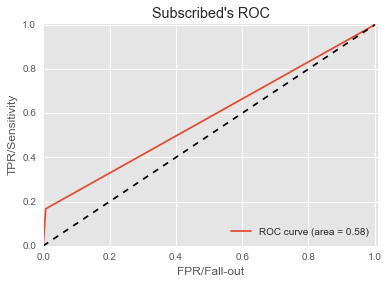

In [270]:
fpr, tpr, thresholds = metrics.roc_curve(c, c_hat_subscribed)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Subscribed's ROC")
plt.legend(loc = 'lower right')
plt.show()

<i>AUC is pretty small, but still let's count the model's accuracy with test and train data.</i>

<h3><i>Let's split the dataset into train and test data, and check model's accuracy:</i></h3>

In [271]:
train_df = df.sample(frac = .6)
test_df = df.drop(train_df.index)

<i>Using same features:</i>

In [272]:
features = ['sessions', 'dob_given', 'focus', 'gender', 
            'exp_2', 'exp_3', 'exp_4']
def X_subs(df):
    X = df[features]
    subs = df.subscribedYN
    return X, subs

train_X, train_subs = X_subs(train_df)
test_X, test_subs = X_subs(test_df)

In [273]:
model = linear_model.LogisticRegression(C=10**2).fit(train_X,train_subs)
print model.intercept_
print model.coef_

[-5.71682]
[[ 0.13477839  0.66511121  0.29860546 -0.09304655  1.19737024  2.13731184
   3.83469675]]


In [274]:
print 'training data model accuracy: ', model.score(train_X,train_subs)
print 'testing data model accuracy: ', model.score(test_X,test_subs)
print 'training err: ', 1 - model.score(train_X,train_subs)
print 'testing err: ', 1 - model.score(test_X,test_subs)

training data model accuracy:  0.941893575369
testing data model accuracy:  0.947410571276
training err:  0.0581064246307
testing err:  0.052589428724


<i>Although the model shows a good score, I think, it's overfitting. AUC is 0.58 which is low. Predictions don't seem to be very accurate. My guess, is that the problem related to the low amount of subscribed users. <br>I will try to build a k-NN model and then, propably, will have to sample the data I have.</i>

<h4><i>Let's try k-NN (there's no assumption of disctribution):</i></h4>

In [275]:
df = original_df(df)
df.head()

,subscribedYN,sec,sessions,series,experience,focus,gender,dob_given
0,1,225,1,0,2,0,1,1
1,0,1795,1,0,3,1,0,1
2,1,3750,9,2,4,0,0,1
3,0,635,2,0,3,0,0,1
4,1,810,4,0,4,0,0,1


In [276]:
X = df [ ['sessions', 'experience', 'dob_given', 'focus'] ]
c = df.subscribedYN

<i>Splitting into train and test data:</i>

In [277]:
train_X, test_X, train_c, test_c = cross_validation.train_test_split(X, c, train_size = .6)

In [278]:
#train_X = train_df[ ['sessions', 'experience', 'dob_given', 'focus'] ]
#train_c = train_df.subscribedYN

scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = scaler.transform(train_X)

model = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'uniform').fit(train_X, train_c)

model.score(train_X, train_c)

0.95025805303434774

In [279]:
test_X = scaler.transform(test_X)
model.score(test_X, test_c)

0.93886812600106784

In [280]:
model_Subs = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'uniform').fit(X, c)
c_hat_subscribed = model_Subs.predict(X)

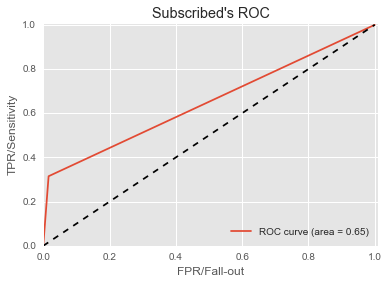

In [281]:
fpr, tpr, thresholds = metrics.roc_curve(c, c_hat_subscribed)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Subscribed's ROC")
plt.legend(loc = 'lower right')
plt.show()

<i>Before starting optimizing the model, let's check the predictions:</i>

In [282]:
predict_X = pd.DataFrame({'sessions': [1,10,50,2000000],
        'experience': [1,2,3,4],
        'dob_given':[0,0,1,1],
        'focus':[0,0,0,0]})

predict_X = predict_X[  ['sessions', 'experience', 'dob_given', 'focus'] ]

predict_X = scaler.transform(predict_X)

predict_c = model.predict(predict_X)
predict_c

array([0, 0, 1, 1])

<i>This model looks better, predictions seems to be more accurate, but AUC = 0.65 which is still low. 
<br>Model accuracy is about 95%, probably those are mine 'not-subscribed' users. 
<br><h3>Let's try to sample the data, so we have even amount of subscribed and not-subscribed users:</h3></i>

In [283]:
df = original_df(df)
s_df = df[df.subscribedYN==1]
s_df.shape

(1099, 8)

In [284]:
ns_df = df[df.subscribedYN==0].sample(n=1099, random_state = 0)
ns_df.shape

(1099, 8)

In [285]:
df = pd.concat([s_df, ns_df])

<i>We received a new data frame with even amount of subscribed and not subscribed users.</i>

In [286]:
df.shape

(2198, 8)

<h3><i>Feature engineering:</i></h3>

In [287]:
df.columns

Index([u'subscribedYN', u'sec', u'sessions', u'series', u'experience',
       u'focus', u'gender', u'dob_given'],
      dtype='object')

In [288]:
df ['SecPSession'] = df.sec/df.sessions

In [289]:
df.corr()

,subscribedYN,sec,sessions,series,experience,focus,gender,dob_given,SecPSession
subscribedYN,1.000000,0.487719,0.406437,0.171296,0.423172,0.072185,-0.042195,0.120278,0.418673
sec,0.487719,1.000000,0.812597,0.524101,0.196826,-0.016025,-0.011353,0.029188,0.364564
sessions,0.406437,0.812597,1.000000,0.616666,0.117228,-0.109017,0.021473,-0.066369,0.044233
series,0.171296,0.524101,0.616666,1.000000,0.053423,-0.038696,0.008138,-0.032811,0.029222
experience,0.423172,0.196826,0.117228,0.053423,1.000000,0.191144,-0.068383,0.017348,0.289308
focus,0.072185,-0.016025,-0.109017,-0.038696,0.191144,1.000000,-0.044356,-0.020565,0.303925
gender,-0.042195,-0.011353,0.021473,0.008138,-0.068383,-0.044356,1.000000,-0.064193,-0.083324
dob_given,0.120278,0.029188,-0.066369,-0.032811,0.017348,-0.020565,-0.064193,1.000000,0.206056
SecPSession,0.418673,0.364564,0.044233,0.029222,0.289308,0.303925,-0.083324,0.206056,1.000000


<h3><i>New k-NN (subscribed users data + sample data for not subscribed users):</i></h3>
<i>Let's try again:</i>

In [290]:
#Rebuilding:
X = df[['sessions', 'experience', 'SecPSession', 'dob_given']]
c = df.subscribedYN

train_X, test_X, train_c, test_c = cross_validation.train_test_split(X, c, train_size = .6, random_state = 0)

scaler = preprocessing.MinMaxScaler().fit(train_X)

train_X = scaler.transform(train_X)

model = neighbors.KNeighborsClassifier(n_neighbors = 9, weights = 'uniform').fit(train_X, train_c)
model.score(train_X, train_c)

0.86267071320182098

<h4><i>Grid search:</i></h4>

In [291]:
k_cv = 10 # 10-fold CV
k_nn = range(1, 30 * (k_cv - 1) / k_cv) # k-NN

gs = grid_search.GridSearchCV(
    estimator = neighbors.KNeighborsClassifier(),
    param_grid = {'n_neighbors': k_nn, 'weights': ['uniform', 'distance']},
    cv = cross_validation.KFold(df.shape[0], n_folds = k_cv)
)

gs.fit(X, c)

score_df = pd.DataFrame({'k': [score.parameters['n_neighbors'] for score in gs.grid_scores_],
    'score': [score.mean_validation_score for score in gs.grid_scores_],
    'weights': [score.parameters['weights'] for score in gs.grid_scores_]})

score_df

,k,score,weights
0,1,0.723385,uniform
1,1,0.723385,distance
2,2,0.707006,uniform
3,2,0.735214,distance
4,3,0.758872,uniform
...,...,...,...
47,24,0.764786,distance
48,25,0.764786,uniform
49,25,0.764786,distance
50,26,0.759782,uniform


In [292]:
score_df[score_df.score == score_df.score.max()]

,k,score,weights
40,21,0.77252,uniform


<h4><i>Let's use k = 21, weights = 'uniform': </i></h4>

In [293]:
#Rebuilding:
X = df[['sessions', 'experience', 'SecPSession', 'dob_given']]
c = df.subscribedYN

train_X, test_X, train_c, test_c = cross_validation.train_test_split(X, c, train_size = .6, random_state = 0)

scaler = preprocessing.MinMaxScaler().fit(train_X)

train_X = scaler.transform(train_X)

model = neighbors.KNeighborsClassifier(n_neighbors = 21, weights = 'uniform').fit(train_X, train_c)
model.score(train_X, train_c)

0.84825493171471922

<i>k = 21 shows the best result with an accuracy close to 84,8%. 
This accuracy is a little lower than with k = 9, but it is more reliable (because of CV).</i>

<h4><i>AUC:</i></h4>

In [294]:
model_Subs = neighbors.KNeighborsClassifier(n_neighbors = 21, weights = 'uniform').fit(X, c)
c_hat_subscribed = model_Subs.predict(X)

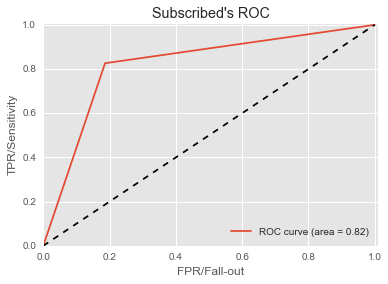

In [295]:
fpr, tpr, thresholds = metrics.roc_curve(c, c_hat_subscribed)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Subscribed's ROC")
plt.legend(loc = 'lower right')
plt.show()

In [296]:
predict_X = pd.DataFrame({'sessions': [10,10,10,10],
        'experience': [1,2,3,4],
        'SecPSession':[210,210,210,210],
        'dob_given':[0,0,0,0]})
predict_X = predict_X[  ['sessions', 'experience', 'SecPSession', 'dob_given'] ]

predict_X = scaler.transform(predict_X)


predict_c = model.predict(predict_X)
predict_c

array([0, 0, 1, 1])

<i>Looks better. Note, for 2nd and 3rd prediction I used the same amount of sessions, same SecPSession and dob_given, but I changed the experience level from 2 to 3. As a result, 2nd prediction is 0, and 3rd is 1. <br> Model works, and experience level obviously influence user's subscription.</i>

<h3><i>New logistic regression model (without SecPSession)</i></h3>

In [297]:
experience_df = pd.get_dummies(df.experience, prefix = 'exp')

experience_df.rename(columns = {'exp_1.0': 'exp_1',
                              'exp_2.0': 'exp_2',
                              'exp_3.0': 'exp_3',
                              'exp_4.0': 'exp_4'}, inplace = True)
df = df.join(experience_df)
df.drop(['experience'], axis = 1, inplace = True)
df.head()

,subscribedYN,sec,sessions,series,focus,...,SecPSession,exp_1,exp_2,exp_3,exp_4
0,1,225,1,0,0,...,225.000000,0.0,1.0,0.0,0.0
2,1,3750,9,2,0,...,416.666667,0.0,0.0,0.0,1.0
4,1,810,4,0,0,...,202.500000,0.0,0.0,0.0,1.0
17,1,1605,5,0,0,...,321.000000,0.0,0.0,0.0,1.0
20,1,355,1,0,0,...,355.000000,0.0,0.0,1.0,0.0


In [298]:
model = smf.logit(formula = 'subscribedYN ~ sessions + \
                dob_given + focus + exp_2 + exp_3 + exp_4', data = df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.437484
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           subscribedYN   No. Observations:                 2198
Model:                          Logit   Df Residuals:                     2191
Method:                           MLE   Df Model:                            6
Date:                Tue, 15 Nov 2016   Pseudo R-squ.:                  0.3688
Time:                        09:56:19   Log-Likelihood:                -961.59
converged:                       True   LL-Null:                       -1523.5
                                        LLR p-value:                1.411e-239
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -3.7732      0.213    -17.687      0.000        -4.191    -3.355
sessions       0.2245      0.012     17.979      0.000         0.200     0.249
dob_given      1.0283      0.118      8.728      0.000         0.797     1.259
focus          0.5335      0.167      3.187      0.001         0.205     0.862
exp_2          1.3050      0.206      6.342      0.000         0.902     1.708
exp_3          1.9318      0.190     10.191      0.000         1.560     2.303
exp_4          3.8488      0.251     15.321      0.000         3.356     4.341
==============================================================================
"""

In [299]:
np.exp(model.params)

Intercept     0.022979
sessions      1.251758
dob_given     2.796174
focus         1.704935
exp_2         3.687559
exp_3         6.902214
exp_4        46.936913
dtype: float64

In [300]:
predict_X = pd.DataFrame({'intercept': [1,1,1,1],
        'sessions': [10,10,15,15],
        'focus':[0,0,0,0],
        'dob_given':[1,1,1,1],
        'exp_2': [0,1,0,0],
        'exp_3': [0,0,1,0],
        'exp_4': [0,0,0,1]})
model.predict(predict_X)

array([ 0.37767037,  0.6911533 ,  0.92791795,  0.98870572])

<h3><i>Sklearn</i></h3>

In [301]:
X = df[ ['sessions', 'dob_given', 'focus', 'exp_2','exp_3','exp_4'] ]
c = df.subscribedYN

features = ['sessions', 'dob_given', 'focus', 'exp_2', 'exp_3', 'exp_4']

model = linear_model.LogisticRegression(C=10**2).fit(X,c)

print "Model score: ",model.score(X,c)
print "Intercept:", np.exp(model.intercept_)
zip(features, model.coef_[0])

Model score:  0.798908098271
Intercept: [ 0.02326044]


[('sessions', 0.2242642381031674),
 ('dob_given', 1.026903534256836),
 ('focus', 0.53297409456266231),
 ('exp_2', 1.2947018758298643),
 ('exp_3', 1.9217662412994572),
 ('exp_4', 3.8375773807755045)]

<h4><i>AUC:</i></h4>

In [302]:
model_Subs = linear_model.LogisticRegression(C=10**2).fit(X, c)
c_hat_subscribed = model_Subs.predict(X)

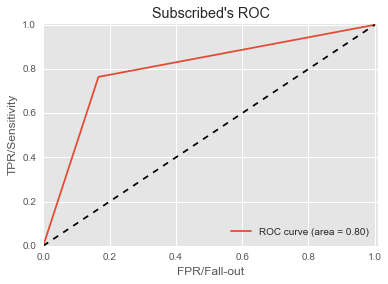

In [303]:
fpr, tpr, thresholds = metrics.roc_curve(c, c_hat_subscribed)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Subscribed's ROC")
plt.legend(loc = 'lower right')
plt.show()

<h4><i>When I split the data:</i></h4>

In [304]:
train_df = df.sample(frac = .6)
test_df = df.drop(train_df.index)

train_X, train_subs = X_subs(train_df)
test_X, test_subs = X_subs(test_df)

In [305]:
model = linear_model.LogisticRegression(C=10**2).fit(train_X,train_subs)

print 'training data model accuracy: ', model.score(train_X,train_subs)
print 'testing data model accuracy: ', model.score(test_X,test_subs)
print 'training err: ', 1 - model.score(train_X,train_subs)
print 'testing err: ', 1 - model.score(test_X,test_subs)

training data model accuracy:  0.799848369977
testing data model accuracy:  0.803185437998
training err:  0.200151630023
testing err:  0.196814562002


<i>I get similar model accuracy: about 80%.</i>

In [306]:
# predict_X.drop('intercept',axis = 1, inplace = True)
predict_X = predict_X[['sessions', 'focus', 'dob_given', 
         'exp_2', 'exp_3', 'exp_4']]
print model.predict(predict_X)
print model.predict_proba(predict_X).round(4)

[0 1 1 1]
[[ 0.6776  0.3224]
 [ 0.4119  0.5881]
 [ 0.1198  0.8802]
 [ 0.0216  0.9784]]


<h3><i>Let's compare with Logistic regression model with SecPSession feature:</i></h3>

<h4><i>Statsmodels and sklearn </i></h4>

In [307]:
model = smf.logit(formula = 'subscribedYN ~ sessions +\
               SecPSession + dob_given + exp_2 + exp_3 + exp_4', data = df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.375269
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           subscribedYN   No. Observations:                 2198
Model:                          Logit   Df Residuals:                     2191
Method:                           MLE   Df Model:                            6
Date:                Tue, 15 Nov 2016   Pseudo R-squ.:                  0.4586
Time:                        09:56:20   Log-Likelihood:                -824.84
converged:                       True   LL-Null:                       -1523.5
                                        LLR p-value:                8.886e-299
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      -4.6120      0.244    -18.905      0.000        -5.090    -4.134
sessions        0.1972      0.013     15.654      0.000         0.173     0.222
SecPSession     0.0045      0.000     13.370      0.000         0.004     0.005
dob_given       0.4748      0.133      3.581      0.000         0.215     0.735
exp_2           1.3716      0.223      6.137      0.000         0.934     1.810
exp_3           1.7275      0.207      8.327      0.000         1.321     2.134
exp_4           3.5650      0.271     13.151      0.000         3.034     4.096
===============================================================================
"""

In [308]:
#results with sklearn:
X = df[ ['sessions', 'SecPSession', 'dob_given', 'exp_2','exp_3','exp_4'] ]
c = df.subscribedYN

features = ['sessions','SecPSession','dob_given', 'exp_2', 'exp_3', 'exp_4']

model = linear_model.LogisticRegression(C=10**2).fit(X,c)

print "Model score: ", model.score(X,c)
print "Intercept:", model.intercept_
zip(features, model.coef_[0])

Model score:  0.848043676069
Intercept: [-4.56694098]


[('sessions', 0.19612109448989948),
 ('SecPSession', 0.0044763285344718252),
 ('dob_given', 0.47108441674119594),
 ('exp_2', 1.3403465287449012),
 ('exp_3', 1.6990181149319732),
 ('exp_4', 3.5253573187364653)]

<i>Splitting into train and test data:</i>

In [309]:
train_df = df.sample(frac = .6)
test_df = df.drop(train_df.index)

def X_subs(df):
    X = df[features]
    subs = df.subscribedYN
    return X, subs

train_X, train_subs = X_subs(train_df)
test_X, test_subs = X_subs(test_df)
model = linear_model.LogisticRegression(C=10**2).fit(train_X,train_subs)
print 'Training data model accuracy: ', model.score(train_X,train_subs)
print 'Testing data model accuracy: ', model.score(test_X,test_subs)

Training data model accuracy:  0.856709628506
Testing data model accuracy:  0.838452787258


<i>AUC:</i>

In [310]:
model_Subs = linear_model.LogisticRegression(C=10**2).fit(X, c)
c_hat_subscribed = model_Subs.predict(X)

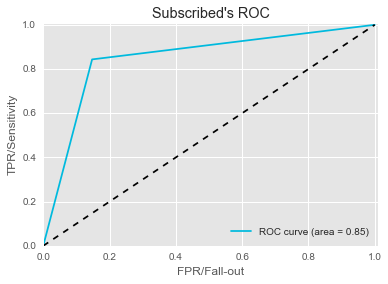

In [311]:
fpr, tpr, thresholds = metrics.roc_curve(c, c_hat_subscribed)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr), color='#00BADE')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Subscribed's ROC")
plt.legend(loc = 'lower right')
plt.show()

<h4><i>Odds Ratios:</i></h4>

In [312]:
pd.crosstab(df.subscribedYN, df.exp_1)

exp_1,0.0,1.0
subscribedYN,,
0,765,334
1,1020,79


<i>Odds of subscribing for not experienced users: 79/334 = 0.24 <br>Other users: 1020/765 = 1.33 <br>Odds ratio: 0.18. <br>Odds of subscribing for not experienced users are 82% lower than other users.</i>

In [313]:
pd.crosstab(df.subscribedYN, df.exp_4)

exp_4,0.0,1.0
subscribedYN,,
0,1057,42
1,828,271


<i>Odds of subscribing for highly experienced users: 271/42 = 6.45 <br>Other users: 828/1057 = 0.78 <br>Odds ratio: 8.27. <br>Odds of subscribing for highly experienced users are 8.27 times higher than other users.</i>

In [314]:
zip(features, np.exp(model.coef_[0]))

[('sessions', 1.2102196523153705),
 ('SecPSession', 1.0048013412548247),
 ('dob_given', 1.484088262769556),
 ('exp_2', 3.6642175094400349),
 ('exp_3', 5.3451558440113072),
 ('exp_4', 31.05944373958852)]

<i>Users with experience = 2 (low) have 4 times more odds of subscribing comparing to users with experience = 1 (none).</i>

In [316]:
predict_X = pd.DataFrame({
        'sessions': [10,10,10,10],
        'SecPSession':[210,210,210,210],
        'dob_given':[0,0,0,0],
        'exp_2': [0,1,0,0],
        'exp_3': [0,0,1,0],
        'exp_4': [0,0,0,1]})
model.predict(predict_X)
predict_X = predict_X[['sessions', 'SecPSession', 'dob_given', 
         'exp_2', 'exp_3', 'exp_4']]
print model.predict(predict_X)
print model.predict_proba(predict_X).round(4)

[0 0 1 1]
[[ 0.8328  0.1672]
 [ 0.5762  0.4238]
 [ 0.4824  0.5176]
 [ 0.1382  0.8618]]


<i>When having same amount of sessions competed (10), seconds per session (210), dob_given(0), we can see that probability of user subscribing is increasing from ~55% to ~87% when users experience level changes from medium to high (3 to 4).</i>